# Holistic Nanowire Laser Characterization as a Route to Optimal Design


 _Stephen Church (stephen.church@manchester.ac.uk)_,  _Nikesh Patel_, _Ruqaiya Al-Abri_, _Nawal Al-Amairi_, _Patrick Parkinson (patrick.parkinson@manchester.ac.uk)_

**Department of Physics and Astronomy and the Photon Science Institute, University of Manchester, United Kingdom**

_Yunyan Zhang (yunyanzhang@zju.edu.cn)_

**School of Micro-Nano Electronics, Zhejiang University, China**

_Huiyun Liu (huiyun.liu@ucl.ac.uk)_

**Department of Electronic and Electrical Engineering, UCL, United Kingdom**

---
This notebook shows how to manipulate and experiment with the dataset associated with the research paper at  [arXiv:2210.06958](https://arxiv.org/abs/2210.06958). The master dataset consists of a number of parameters over a large population, which were determined through analysis of the raw data, which is also provided.

## Dataset Format
The data is provided as a structured H5 file at [DOI:10.48420/21865785](https://dx.doi.org/10.48420/21865785), which provides correlated datasets of imagery, spectroscopy, and geometrical details. This notebook provides a basic method to explore this dataset and generate correlations associated with this research.

3 files are included:
- **nanowire_parameters.h5**
    - contains the extracted fit parameters from each nanowire in the population, 
    - used for studying statistics and correlations
- **raw_data.h5**
    - contains the raw spectral, image and decay curve data for each nanowire
    - used for fitting to extract characteristic parameters
    - This is a large file (~4GB)
- **metadata.h5**
    - contains the useful metadata for each type of measurement, typically the x-axis for spectral measurements
   

In [ ]:
# Required to download the dataset
import urllib.request as url
import os   
import zipfile
import progressbar
# Required to import the dataset
import tables
# Required to process the dataset
import numpy as np
import scipy.signal as sig
# Required to visualize the dataset
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Useful progressbar for downloading dataset
class MyProgressBar():
    def __init__(self):
        self.pbar = None

    def __call__(self, block_num, block_size, total_size):
        if not self.pbar:
            self.pbar=progressbar.ProgressBar(maxval=total_size)
            self.pbar.start()

        downloaded = block_num * block_size
        if downloaded < total_size:
            self.pbar.update(downloaded)
        else:
            self.pbar.finish()

# Path to download
download_path = 'https://figshare.manchester.ac.uk/ndownloader/files/38837358'

# Download data
if not os.path.isfile('nanowire_parameters.h5'):
    print('Downloading dataset')
    url.urlretrieve(download_path,'nanowire_data.zip', MyProgressBar())
    with zipfile.ZipFile(f'nanowire_data.zip', 'r') as zip_ref:
        print('Extracting zip file')
        zip_ref.extractall()
        print('...done.')
else:
    print('Dataset already downloaded')

100% (462367974 of 462367974) |##########| Elapsed Time: 0:00:17 Time:  0:00:17


Extracting zip file
...done.


In [ ]:
# Open parameter data
datafile_reference = tables.open_file('nanowire_parameters.h5',mode='r')
dataset = datafile_reference.root.nanowires
print(f'The dataset contains {dataset.ID.shape[1]} structures')

#Open metadata
metadata_reference = tables.open_file('metadata.h5',mode='r')
metadata = metadata_reference.root.metadata

#Open raw data
rawdata_reference = tables.open_file('raw_data.h5',mode='r')
rawdata = rawdata_reference.root.raw_data

The dataset contains 5313 structures


---
## Show the data

nanowire_parameters.h5 contains data including:
- **ID** : unique nanowire ID
- **position** : position (mm) on substrate (x,y,z)
- **length** : length (um) determined by optical microscope
- **width** : width (um) determined by SEM 
- **bandgap_QW(1,2)** : bandgaps (eV) of 2 different QWs extracted from LSW fit to spectral data
- **width_QW(1,2)** : widths (nm) of 2 different QWs, assuming zero strain and considering a finite QW model.
- **Urbach_energy** : (eV) extracted from LSW fit to spectral data
- **PL_int** : relative intensity of the low power PL spectra
- **sigma** : (eV) homogeneous broadening parameter in LSW fit to spectral data
- **(low,high)_lifetime** : (ns) carrier recombination lifetime extracted through a stretched exponential fit to the TCSPC measurements at low power and close to threshold
- **(low,high)_order** : stretched exponential factor extracted through a stretched exponential fit to the TCSPC measurements at low power and close to threshold
- **threshold_(fluence,carriers)** : (uJ/cm^2,1/cm^2) Lasing threshold fluence and carrier density, extracted from power dependent measurements
- **lasing_wl** : (nm) Wavelength of the primary lasing mode at threshold
- **coherence_length** : (mm) Coherence length of the lasing emission at threshold, extracted from interferoemtry measurements
- **reflectivity** : Reflectivity of the lasing cavity at threshold, extracted from interferoemtry measurements
- **losses** : (1/cm) Distributed losses in the laser cavity, extractred from the linescan experiments
- **mode_spacing** : (meV) Mode spacing of the higher order lasing modes above threshold.
- **reflectivity_separate** : Reflectivity of each nanowire facet, calculated from imaging experiments.
- **IQE_est** : Estimated IQE, calculated through a combination of TCSPC and power dependence measurements.
  
raw_data.h5 contains the data for the following experiments:
- **images.(optical,SEM,PL,lasing)** : images of nanowires recorded with different experiments.
- **PL.spectra** : photoluminescence spectra recorded at low excitation power
- **TCSPC.(low,high)_decay** : TCSPC decays measured at low power and close to threshold.
- **power_dependence.(power,spectra,rates)** : Power dependent PL measurements, with recorded power (in mW), PL spectra at each power, and estimated A,B,C recombination rates.
- **interferometry.interferogram** : Interferogram measured at threshold.
- **linescan.(position,intensity)** : Intensity versus position (um) data for the linescan experiment to find the distributed losses.

metadata.h5 contains the data for the following experiments:
- **images.pix_size** : pixel size for the optical images (um).
- **PL.(wl,spot_size)** : x axis (nm) for low power spectra and excitation spot size (um) for measurement.
- **TCSPC.(time,spot_size)** : x axis (ns) for low power spectra and excitation spot size (um) for measurement.
- **power_dependence.(wl,spot_size)** : x axis (nm) for power dependent spectra and excitation spot size (um) for measurement.
- **interferometry.delta** : x axis (mm) for interferogram..
---
### Filtering
Not every structure has every measurement associated with it. We can prepare a subset of the data that contains PL, TCSPC, lasing and reflectivity data as "complete_ids", by looking for datasets that are not empty.

In [ ]:
PL = dataset.bandgap_QW1[:]>0
TCSPC = dataset.low_lifetime[:]>0
lasing = dataset.threshold_fluence[:]>0
refl = dataset.reflectivity[:]>0
losses = dataset.losses[:] > 0
lasing_ids = np.where(PL & TCSPC & lasing)
refl_ids = np.where(PL & TCSPC & lasing & refl)
complete_ids = np.where(PL & TCSPC & lasing & refl & losses)

print(f'A total of {lasing_ids[0].size} structures have PL, TCSPC and lasing measurements.')
print(f'A total of {refl_ids[0].size} structures have PL, TCSPC and lasing, reflectivity measurements.')
print(f'A total of {complete_ids[0].size} structures have all PL, TCSPC, lasing, reflectivity and losses measurements.')

A total of 3463 structures have PL, TCSPC and lasing measurements.
A total of 539 structures have PL, TCSPC and lasing, reflectivity measurements.
A total of 112 structures have all PL, TCSPC, lasing, reflectivity and losses measurements.


We define a couple of helper functions for smoothing (s) and normalization (n), and extract the wavelength axis (wl) and time axis (xt) for the primary data sets.

In [ ]:
# Helper functions
# Smooth
s = lambda x:sig.medfilt(x,kernel_size=11)
# Normalize
n = lambda x:x/np.max(x)
# Wavelength and time axes - one for low and one for high power, with different zero offsets determined experimentally
wl = metadata.PL.wl
xt_low = np.array(metadata.TCSPC.time) - 0.67
xt_high = np.array(metadata.TCSPC.time) - 1.23

### Selecting a dataset to visualise
The first "complete" wire is selected; the first ID which contains PL and both top and bottom excitation TCSPC. All of the datasets arising from this are collected.

	ID : 9
	IQE_est : 0.4
	PL_int : 4.47e+03
	Urbach_energy : 0.0121
	bandgap_QW1 : 1.55
	bandgap_QW2 : 1.6
	coherence_length : 0.374
	high_lifetime : 2.57
	high_order : 0.99
	lasing_wl : 765
	length : 17.6
	losses : 1.12e+03
	low_lifetime : 1.58
	low_order : 0.811
	mode_spacing : 10.4
	position : ['-0.0332', '0.105', '-7.86e-07']
	reflectivity : 0.368
	reflectivity_separate : ['0.278', '0.488']
	sigma : 0.0189
	threshold_carriers : 4.11e+15
	threshold_fluence : 150
	width : 0.723
	width_QW1 : 4.53
	width_QW2 : 3.71


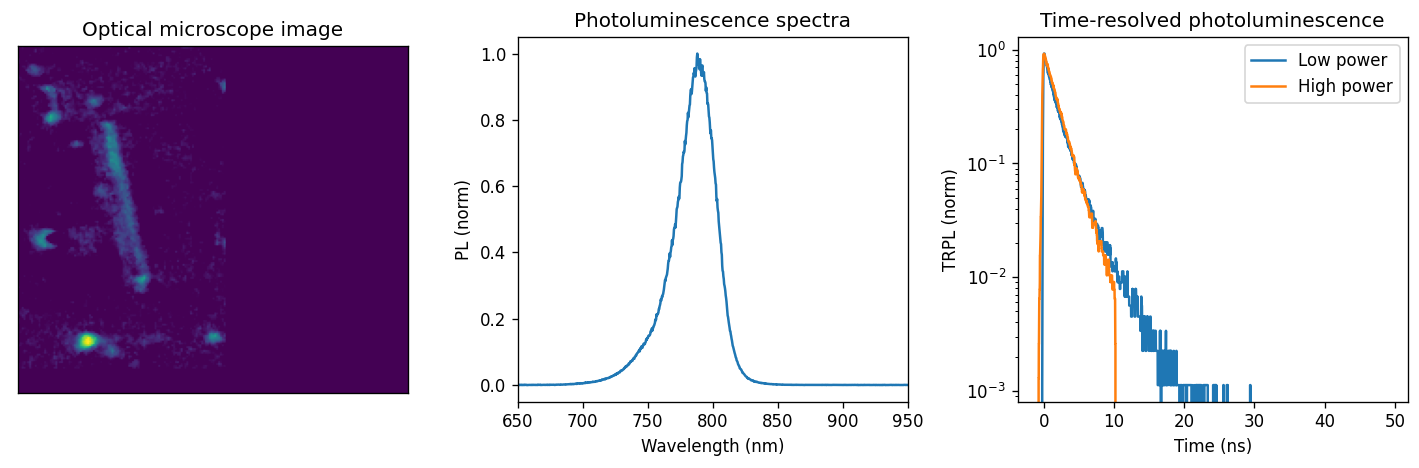

In [ ]:
# Select one structure from the total set which have all key measurements
nanowire = complete_ids[1][0]

# Show all parameters
for k in dataset:
  value = np.squeeze(k[:,nanowire])
  if np.size(value) > 1:
    value = [f'{float(v):.3g}' for v in value]
    print(f'\t{k.name} : {value}')
  else:
    print(f'\t{k.name} : {value:.3g}')

# Create a high-resolution figure
plt.figure(figsize=[12,4],dpi = 120)

# Show optical image
plt.subplot(131)
plt.imshow(rawdata.images.optical[:,:,nanowire])
plt.xticks([])
plt.yticks([])
plt.title('Optical microscope image')

# Show photoluminescence spectra
plt.subplot(132)
plt.plot(wl,n(rawdata.PL.spectra[:,nanowire]))
plt.xlim([650,950])
plt.xlabel('Wavelength (nm)')
plt.ylabel('PL (norm)')
plt.title('Photoluminescence spectra')

# Show TCSPC data
plt.subplot(133)
plt.semilogy(xt_low,s(n(rawdata.TCSPC.low_decay[:,nanowire])),
         xt_high,s(n(rawdata.TCSPC.high_decay[:,nanowire])))
plt.xlabel('Time (ns)')
plt.ylabel('TRPL (norm)')
plt.title('Time-resolved photoluminescence')
plt.legend(['Low power','High power']);

plt.tight_layout()

### Correlation of datasets
The power of this approach is also shown in collections of data across the population - for instance histograms or correlations. We show a length histogram here.

Cutting 2821 of 5313 datasets where length data is missing or unavailable.


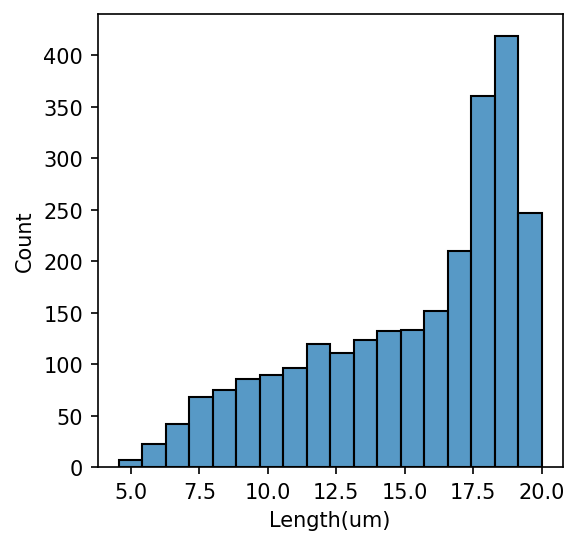

In [ ]:
# Create a numpy array of lengths
l = np.double(dataset.length[:]);

plt.figure(figsize=[4,4],dpi = 150)
# Create histogram, avoiding zero values (where no data is present)
sns.histplot(l[l!=0])
print(f'Cutting {np.sum(l==0)} of {l.size} datasets where length data is missing or unavailable.')
plt.xlabel('Length(um)');

We can also correlate between measurements, for example, lasing threshold and lasing wavelength. This is used in the paper to demonstrate the correlation between these performance mertics, likely to be due to bandfilling effects.

Filtering out 1056 of 5313 datapoints away from central peak to enhance visibility of trend. 4257 structures are used.


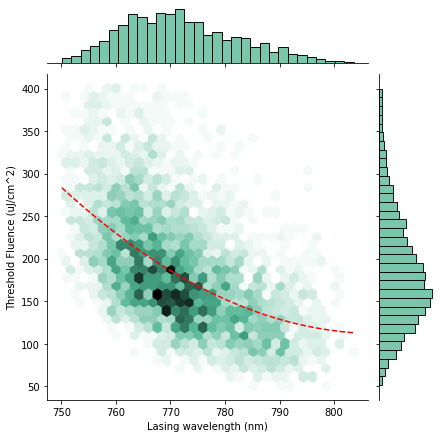

In [ ]:
# Select region close to peak
m = np.where(np.array(dataset.lasing_wl[:]>750)  &
             np.array(dataset.threshold_fluence[:]>0) &
             np.array(dataset.threshold_fluence[:]<400))
print(f'Filtering out {l.size-m[0].size} of {l.size} datapoints away from central peak to enhance visibility of trend. {m[0].size} structures are used.')

# Do a fit for guide to the eye
pf = np.polyfit(dataset.lasing_wl[m],dataset.threshold_fluence[m],deg=2)
xr = np.linspace(np.min(dataset.lasing_wl[m]),np.max(dataset.lasing_wl[m]))

# Produce a 2D hexbin to visualise the scatter,
sns.jointplot(x=dataset.lasing_wl[m], y=dataset.threshold_fluence[m], kind="hex", color="#4CB391")
# Add guide to the eye
plt.plot(xr,np.polyval(pf,xr),'r--')
# Decorate
plt.xlabel('Lasing wavelength (nm)')
plt.ylabel('Threshold Fluence (uJ/cm^2)');